In [16]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score, calinski_harabasz_score
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix
from munkres import Munkres
from scipy.special import comb
from PIL import Image
import random
from sklearn.neighbors import NearestNeighbors
from tabulate import tabulate
import json
seed_num = 114
np.random.seed(seed_num)
from models import cnn_share_attn
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from torchvision.utils import make_grid, save_image
import cv2

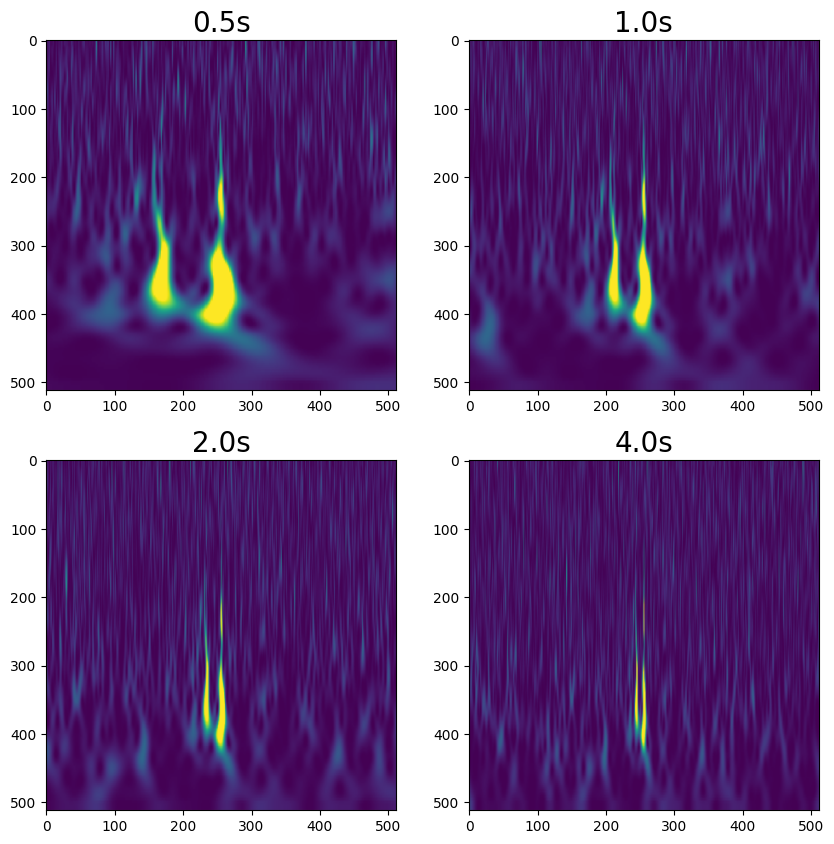

In [32]:
dir = f"../gravityspy/mixed_split/train/sub_0.5/Chirp"
fname = os.listdir(dir)[0]

f, ax = plt.subplots(2, 2, figsize=(10, 10))
for i, scale in enumerate(["sub_0.5", "sub_1.0", "sub_2.0", "sub_4.0"]):
    im = Image.open(f"{dir}/{fname}".replace("0.5", f"{scale.split('_')[1]}"))
    ax[i // 2, i % 2].imshow(im)
    ax[i // 2, i % 2].set_title(scale.split("_")[-1] + "s", fontsize=20)
    


In [24]:

def read_im(fname):
    scale = ["sub_0.5", "sub_1.0", "sub_2.0", "sub_4.0"]
    trans = transforms.Compose([transforms.ToTensor(),
                            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
                                             transforms.Resize(224, antialias=True)])
    
    ims = []
    for scale in scale:
        im = Image.open(fname.replace("0.5", f"{scale.split('_')[1]}"))
        im = trans(im)
        ims.append(im)
    return torch.concat(ims, 0).unsqueeze(0)


device = "cuda"
model = cnn_share_attn().to(device)
model.load_state_dict(torch.load("mix_output/cnn_share_attn/checkpoint_200.pth")["model"])
model.eval()
# classes = [c for c in os.listdir(f"../gravityspy/mixed_split/test/sub_0.5")]
classes = ["Chirp", "Extremely_Loud", "Wandering_Line", "1080Lines"]
fontsizes = [50, 35, 35, 40]
fontsize = 50

f, ax = plt.subplots(4, len(classes) * 2, figsize=(80,40))
for i, c in enumerate(classes):
    with torch.no_grad():
        dir = f"../gravityspy/mixed_split/test/sub_0.5/{c}"
        fname = os.listdir(dir)[0]
        im = read_im(f"{dir}/{fname}").to(device)
        pred, _, _ = model(im)

        im = im.reshape(4, 3, 224, 224).permute(0, 2, 3, 1).cpu().numpy() * 127.5 + 127.5
        im = im.astype(np.uint8)
        pred = pred.reshape(4, 3, 224, 224).permute(0, 2, 3, 1).cpu().numpy() * 127.5 + 127.5
        pred = pred.astype(np.uint8)

        ax[0, 2*i].set_title(f"{c}\nGT", fontsize=fontsize)
        ax[0, 2*i+1].set_title(f"{c}\nRecon", fontsize=fontsize)
        for j in range(4):
            ax[j, 2*i].imshow(im[j])
            ax[j, 2*i + 1].imshow(pred[j])



ax[0, 0].set_ylabel(f"0.5s", fontsize=fontsize, rotation='horizontal', labelpad=160)
ax[1, 0].set_ylabel(f"1.0s", fontsize=fontsize, rotation='horizontal', labelpad=160)
ax[2, 0].set_ylabel(f"2.0s", fontsize=fontsize, rotation='horizontal', labelpad=160)
ax[3, 0].set_ylabel(f"4.0s", fontsize=fontsize, rotation='horizontal', labelpad=160)


ax[1, 0].xlable = "Chirp-Recon"
plt.show()


KeyboardInterrupt: 

In [ ]:
def make_cost_matrix(c1, c2):
    """
    """
    uc1 = np.unique(c1)
    uc2 = np.unique(c2)
    l1 = uc1.size
    l2 = uc2.size
    assert(l1 == l2 and np.all(uc1 == uc2))

    m = np.ones([l1, l2])
    for i in range(l1):
        it_i = np.nonzero(c1 == uc1[i])[0]
        for j in range(l2):
            it_j = np.nonzero(c2 == uc2[j])[0]
            m_ij = np.intersect1d(it_j, it_i)
            m[i,j] =  -m_ij.size
    return m

def translate_clustering(clt, mapper):
    return np.array([ mapper[i] for i in clt ])



def map_label(pred, gt):
    """entry point"""

    num_labels = len(np.unique(gt))

    # cm = confusion_matrix(gt, pred, labels=range(num_labels)) # gets the confusion matrix

    cost_matrix = make_cost_matrix(pred, gt)

    m = Munkres()
    indexes = m.compute(cost_matrix)
    mapper = { old: new for (old, new) in indexes }


    new_labels = translate_clustering(pred, mapper)
    new_cm = confusion_matrix(gt, new_labels, labels=range(num_labels))
    return new_labels, mapper


In [ ]:
def most_vote(nn_class, labels, k):
    cur = 0
    for i in range(nn_class.shape[0]):
        max_num = 0
        for j in range(k):
            if ((nn_class[i, :] == nn_class[i, j]).sum() > max_num) or \
            (k > 1 and (nn_class[i, :] == nn_class[i, j]).sum() == max_num and nn_class[i, j] != labels[i]):
                max_num = (nn_class[i, :] == nn_class[i, j]).sum()
                max_class = nn_class[i, j]
        
        if max_class == labels[i]:
            cur += 1
    return cur


def mean_average_precision(index, label):
    correct = (index == label[:, None]).astype(np.int32)
    precision = np.cumsum(correct, 1) / (np.arange(index.shape[1])[None, :] + 1)
    res = (precision * correct).sum(1) / (correct.sum(1) + 1e-6)
    return res.mean()


In [ ]:
all_data = {}
for model_dir in os.listdir("latent_code"):
    if not os.path.isdir(os.path.join("latent_code", model_dir)):
        continue
    all_data[model_dir] = {}
    for s in ["val", "test"]:
        test_dir = os.path.join("latent_code", model_dir, s)

        num_test = len(os.listdir(test_dir)) // 2

        
        
        print(test_dir)
        print()

        data = []
        labels = []
        fnames = []

        idx_num = [int(fname.split("_")[-1]) for fname in os.listdir(f"{test_dir}") if "im" not in fname]
        idx_num.sort()
        num_file = 0
        classes = [dir for dir in os.listdir(f"{test_dir}/test_{idx_num[0]}")]
        classes.sort()
        for i, dir in enumerate(classes):
            _dir = os.path.join(f"{test_dir}/test_{idx_num[0]}")
            for fname in os.listdir(os.path.join(_dir, dir)):
                num_file += 1


        shuffle_idx = np.arange(num_file)
        # np.random.shuffle(shuffle_idx)



        for idx in idx_num:
            data_tmp = []
            label_tmp = []
            fnames_tmp = []
            for i, dir in enumerate(classes):
                _dir = os.path.join(f"{test_dir}/test_{idx}")
                for fname in os.listdir(os.path.join(_dir, dir)):
                    data_tmp.append(np.load(os.path.join(_dir, dir, fname)))
                    label_tmp.append(i)
                    fnames_tmp.append(os.path.join(_dir, dir, fname))

            data.append(np.nan_to_num(np.vstack(data_tmp))[shuffle_idx, :])
            labels.append(np.array(label_tmp)[shuffle_idx])
            fnames.append(np.array(fnames_tmp)[shuffle_idx])
        all_data[model_dir][s] = dict(data=data, labels=labels, fnames=fnames, idx_num=idx_num)



latent_code/vit/val



KeyboardInterrupt: 

In [ ]:
# for m in sorted(all_data.keys()):
#     for s in all_data[m].keys():
#         data = all_data[m][s]["data"]
#         labels = all_data[m][s]["labels"]
#         fnames = all_data[m][s]["fnames"]
#         idx_num = all_data[m][s]["idx_num"]
#         show_data = {}
#         for idx, num in enumerate(idx_num):
#             ks = [1, 3, 5, 7, 10]
#             knn = NearestNeighbors(n_neighbors=ks[-1] + 1, algorithm='brute').fit(data[idx])
#             distances, indices = knn.kneighbors(data[idx])
#             remove_idx = (indices == np.arange(indices.shape[0])[:, np.newaxis])

#             indices = indices[np.logical_not(remove_idx)].reshape(indices.shape[0], -1)


#             # for k in ks:

#             #     index = indices[:, :k]
#             #     nn_class = labels[idx][index]
#             #     acc = []
                
#             #     for c in range(len(classes)):
#             #         cur = 0
#             #         mask = (labels[idx] == c)
#             #         nn_class_msk = nn_class[mask]
#             #         cur = most_vote(nn_class_msk, labels[idx][mask], k)
                    
#             #         acc.append(cur / nn_class_msk.shape[0])




#             #     total_acc = most_vote(nn_class, labels[idx], k) / nn_class.shape[0]


#             #     # show_data[f"Top{k}_{num}"] =  acc + [total_acc] 
#             #     show_data[f"Top{k}_{num}"] =  [total_acc] 



#             acc = []
#             for k in ks:

#                 index = indices[:, :k]
#                 nn_class = labels[idx][index]
                
            
#                 total_acc = most_vote(nn_class, labels[idx], k) / nn_class.shape[0]
#                 acc.append(total_acc)

#             show_data[f"{num}"] =  acc



#         print(f"============================={m}-{s}================================================")
#         # df = pd.DataFrame(data=show_data, index=classes + ["total"])
#         df = pd.DataFrame(data=show_data, index=[f"Top{k}" for k in ks])
#         print(tabulate(df, headers='keys', tablefmt='fancy_grid', floatfmt=".5f"))



In [ ]:


# for m in sorted(all_data.keys()):
#     for s in all_data[m].keys():
#         data = all_data[m][s]["data"]
#         labels = all_data[m][s]["labels"]
#         fnames = all_data[m][s]["fnames"]
#         idx_num = all_data[m][s]["idx_num"]
#         show_data = {}
#         for idx, num in enumerate(idx_num):
            
#             ks = [1, 3, 5, 7, 10]

#             knn = NearestNeighbors(n_neighbors=ks[-1] + 1, algorithm='brute').fit(data[idx])
#             distances, indices = knn.kneighbors(data[idx])
#             remove_idx = (indices == np.arange(indices.shape[0])[:, np.newaxis])
#             indices = indices[np.logical_not(remove_idx)].reshape(indices.shape[0], -1)


#             nn_class = labels[idx][indices]
#             acc = []
            
#             for c in range(len(classes)):
#                 mask = (labels[idx] == c)
#                 nn_class_msk = nn_class[mask]
#                 cur = mean_average_precision(nn_class_msk, labels[idx][mask])
#                 acc.append(cur)




#             total_acc = mean_average_precision(nn_class, labels[idx])


#             # show_data[f"mAP_{num}"] =  acc + [total_acc] 
#             show_data[f"mAP_{num}"] =  [total_acc] 
                
#         print(f"============================={m}-{s}================================================")

#         # df = pd.DataFrame(data=show_data, index=classes + ["total"])
#         df = pd.DataFrame(data=show_data, index=["total"])
#         print(tabulate(df, headers='keys', tablefmt='fancy_grid', floatfmt=".5f"))




In [ ]:
from sklearn.metrics import calinski_harabasz_score
seed_num = 114
def confusion(actual, pred):

    tp_plus_fp = comb(np.bincount(actual), 2).sum()
    tp_plus_fn = comb(np.bincount(pred), 2).sum()
    A = np.c_[(actual, pred)]
    tp = sum(comb(np.bincount(A[A[:, 0] == i, 1]), 2).sum()
             for i in set(actual))
    fp = tp_plus_fp - tp
    fn = tp_plus_fn - tp
    tn = comb(len(A), 2) - tp - fp - fn
    return tp, tn, fp, fn

for m in sorted(all_data.keys()):
    for s in all_data[m].keys():
        
        data = all_data[m][s]["data"]
        labels = all_data[m][s]["labels"]
        fnames = all_data[m][s]["fnames"]
        idx_num = all_data[m][s]["idx_num"]
        show_data = {}
        for idx, num in enumerate(idx_num):
            kmeans = KMeans(n_clusters=len(classes), init="random", random_state=seed_num, n_init="auto").fit(data[idx])
            tp, tn, fp, fn = confusion(labels[idx], kmeans.labels_)
            total_prec = tp / (tp + fp)
            total_rec = tp / (tp + fn)
            total_acc = (tp + tn) / (tp + tn + fp + fn)
            total_ari = adjusted_rand_score(labels[idx], kmeans.labels_)
            total_nmi = normalized_mutual_info_score(labels[idx], kmeans.labels_)
            try:
                total_calinski_harabasz_score = calinski_harabasz_score(data[idx], kmeans.labels_)
            except:
                total_calinski_harabasz_score = None

            show_data[f"{num}"] = [f"{total_prec}", f"{total_rec}", f"{total_acc}", f"{total_calinski_harabasz_score}", f"{total_ari}", f"{total_nmi}"]









    
        print(f"============================={m}-{s}================================================")
        df = pd.DataFrame(data=show_data, index=["precision", "recall", "accuracy", "calinski harabaszscore", "adjusted RI", "nmi"])
        print(tabulate(df, headers='keys', tablefmt='fancy_grid', floatfmt=".5f"))



In [ ]:
best_model = {"cnn" : 180, "vit" : 2, "conformer" : 60, "cnn_nofuse_attn" : 20, "cnn_concat_attn" : 160, "cnn_share_attn" : 200, "direct" : 0, "vat1" : 140, "vat5" : 200}

with open("latent_code/l1_l2.json") as fh:
    l1_l2 = json.load(fh)

for s in ["test"]:
    show_data = {}
    for m in best_model.keys():

        data = all_data[m][s]["data"]
        labels = all_data[m][s]["labels"]
        fnames = all_data[m][s]["fnames"]
        idx_num = all_data[m][s]["idx_num"]
        for idx, num in enumerate(idx_num):
            if num != best_model[m]:
                continue
            
            ks = [1, 3, 5, 7, 10]


            knn = NearestNeighbors(n_neighbors=ks[-1] + 1, algorithm='brute').fit(data[idx])
            distances, indices = knn.kneighbors(data[idx])
            remove_idx = (indices == np.arange(indices.shape[0])[:, np.newaxis])
            indices = indices[np.logical_not(remove_idx)].reshape(indices.shape[0], -1)

            nn_class = labels[idx][indices]

            mean_ap = mean_average_precision(nn_class, labels[idx])
            

            kmeans = KMeans(n_clusters=len(classes), init="random", random_state=seed_num, n_init="auto").fit(data[idx])
            tp, tn, fp, fn = confusion(labels[idx], kmeans.labels_)
            total_ari = adjusted_rand_score(labels[idx], kmeans.labels_)
            total_nmi = normalized_mutual_info_score(labels[idx], kmeans.labels_)
            total_prec = tp / (tp + fp)
            total_rec = tp / (tp + fn)
            total_acc = (tp + tn) / (tp + tn + fp + fn)
            total_calinski_harabasz_score = calinski_harabasz_score(data[idx], kmeans.labels_)

            l1 = eval(l1_l2[f"{m}_{s}_{num}"].split()[2]) if f"{m}_{s}_{num}" in l1_l2 else None
            l2 = eval(l1_l2[f"{m}_{s}_{num}"].split()[5]) if f"{m}_{s}_{num}" in l1_l2 else None


            # show_data[f"{m}-{s}"] = [most_vote(nn_class, labels[idx], k) / nn_class.shape[0] for k in ks] + [mean_ap, total_prec, total_rec, total_acc, total_calinski_harabasz_score, total_ari, total_nmi] 
            show_data[f"{m}-{s}"] = [l2, total_ari, total_nmi] 


    pd.set_option("display.precision", 2)
    df = pd.DataFrame(data=show_data, index=["l2", "ari", "nmi"])

    # print(tabulate(df, headers='keys', tablefmt='latex_raw', floatfmt=".5f"))
    print(tabulate(df, headers='keys', tablefmt='fancy_grid', floatfmt=".4f"))



In [ ]:
nums = {"val" : 4169, "test" : 8340}

for m in all_data.keys():
    for s in all_data[m].keys():
        for dir in os.listdir(os.path.join("latent_code", m, s)):
            if "im" in dir:
                continue
            count = sum([len(list(os.listdir(os.path.join("latent_code", m, s, dir, i)))) for i in os.listdir(os.path.join("latent_code", m, s, dir))])
            if count != nums[s]:
                print(f"{os.path.join(m, s, dir)} : {count}")

In [ ]:
# show_data = {}
# for idx in range(num_test):
#     kmeans = KMeans(n_clusters=len(classes), random_state=0, n_init="auto").fit(data[idx])
#     acc = []
#     total_mis = 0
#     clusters = []
#     new_cluster, cluster_map = map_label(kmeans.labels_, labels[idx])
#     # cluster_map = {classes[old] : new for old, new in cluster_map.items()}
#     # print(cluster_map)
#     for i in range(len(classes)):
#         mask = (labels[idx] == i)
#         cluster = new_cluster[mask]
#         cur_acc = (cluster == i).mean()
#         acc.append(f"{cur_acc: .2f}")
#         clusters.append(cluster)
#         # if classes[i] == "Violin_Mode" or i == 0:
#         #     print(kmeans.labels_[mask])

#     cluster_class = classes
#     # cluster_class = [""] * len(classes)
#     # for k,v in cluster_map.items():
#     #     cluster_class[v] += f"/{k}"

#     # for i in range(len(cluster_class)):
#     #     if cluster_class[i] == "":
#     #         cluster_class[i] = "None"


#     show_data[f"mAP_{20 * idx + 20}"] = acc + [(new_cluster == labels[idx]).mean()]

#     # print(cluster_map)


# df = pd.DataFrame(data=show_data, index=classes + ["total"])
# print(df)


In [ ]:
# class_idx = 0
# mis_class = 0
# mask = (labels == class_idx)
# fname = np.array(fnames)[mask][clusters[class_idx] == mis_class]
# print(fname.shape)
# random.shuffle(fname)
# data = [np.array(Image.open(fname[i][:-4].replace("test", "test_im"))) for i in range(4)]
# data = np.vstack(data)
# fig = plt.figure(figsize=(30, 30)) 
# fig.add_subplot(1, 2, 1)
# plt.imshow(data)
# plt.title(f"{class_idx}-{mis_class}")




# class_idx = 0
# mis_class = 21
# mask = (labels == class_idx)
# fname = np.array(fnames)[mask][clusters[class_idx] == mis_class]
# print(fname.shape)
# random.shuffle(fname)

# data = [np.array(Image.open(fname[i][:-4].replace("test", "test_im"))) for i in range(4)]
# data = np.vstack(data)
# fig.add_subplot(1, 2, 2)
# plt.imshow(data)
# plt.title(f"{class_idx}-{mis_class}")

In [ ]:
# for i, cluster in enumerate(clusters):
#     fig, ax = plt.subplots(figsize=(20, 10))
#     counts, bins, patches = ax.hist(cluster, list(range(len(classes))))
#     ax.set_title(classes[i])
#     ax.set_xlabel("Cluster")
#     ax.set_ylabel("Number")
#     ax.set_xticks(bins + 0.5)
#     ax.set_xticklabels(classes, rotation=60, ha="right")






In [ ]:
from sklearn.manifold import TSNE
data = all_data["cnn_share_attn"]["test"]["data"][9]
labels = all_data["cnn_share_attn"]["test"]["labels"][9]
x_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=3).fit_transform(data)





In [ ]:
import matplotlib._color_data as mcd
palette = list(mcd.XKCD_COLORS.values())[::10]

for i in range(len(classes)):
    mask = (labels == i)
    x_show = x_embedded[mask, :][:500, :]

    plt.figure()
    plt.scatter(x_show[:, 0], x_show[:, 1], color=palette[3 * i])
    plt.title(classes[i])


plt.figure()
for i in range(len(classes)):
    mask = (labels == i)
    x_show = x_embedded[mask, :][:50, :]
    
    plt.scatter(x_show[:, 0], x_show[:, 1], color=palette[3 * i])

plt.figure()
for i in range(len(classes)):
    mask = (labels == i)
    x_show = x_embedded[mask, :][:50, :].mean(0, keepdims=True)
    
    plt.scatter(x_show[:, 0], x_show[:, 1], color=palette[3 * i], label=classes[i])
    plt.legend(bbox_to_anchor=(1.1, 1.05))



In [ ]:
x_embedded = TSNE(n_components=3, learning_rate='auto',
                  init='random', perplexity=3).fit_transform(data)




In [ ]:
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go
from plotly.graph_objs import *

# Configure Plotly to be rendered inline in the notebook.
plotly.offline.init_notebook_mode()







for i in range(len(classes)):
    mask = (labels == i)
    x_show = x_embedded[mask, :][:500, :]
    # Configure the trace.
    trace = go.Scatter3d(
        x=x_show[:, 0],  
        y=x_show[:, 1], 
        z=x_show[:, 2], 
        mode='markers',
        marker={
            'size': 10,
            'opacity': 0.8,
        },
    )

    # Configure the layout.
    layout = go.Layout(
        margin={'l': 0, 'r': 0, 'b': 0, 't': 0},
        scene=Scene(
                xaxis=XAxis(title=classes[i]),
                yaxis=YAxis(title=classes[i]),
                zaxis=ZAxis(title=classes[i])
            )
    )

    data = [trace]

    plot_figure = go.Figure(data=data, layout=layout)

    # Render the plot.
    plotly.offline.iplot(plot_figure)





In [ ]:
data = []
for i in range(len(classes)):
    mask = (labels == i)
    x_show = x_embedded[mask, :][:100, :]
    cluster = kmeans.labels_[mask]
    # mask = cluster == 14
    # x_show = x_show[mask]
    # Configure the trace.
    trace = go.Scatter3d(
        x=x_show[:, 0],  
        y=x_show[:, 1], 
        z=x_show[:, 2], 
        mode='markers',
        marker={
            'size': 10,
            'opacity': 0.8,
        },
    )

    # Configure the layout.
    layout = go.Layout(
        margin={'l': 0, 'r': 0, 'b': 0, 't': 0},
        scene=Scene(
                xaxis=XAxis(title=classes[i]),
                yaxis=YAxis(title=classes[i]),
                zaxis=ZAxis(title=classes[i])
            )
    )

    data.append(trace)

plot_figure = go.Figure(data=data, layout=layout)

# Render the plot.
plotly.offline.iplot(plot_figure)

